# Kickstarter Success Prediction

This notebook builds a machine learning pipeline to predict whether a Kickstarter campaign will succeed or fail.

## 🎯 Objective:
Classify Kickstarter projects as **successful** or **failed** based on historical features.

## 📊 Dataset:
**Source**: [Kickstarter Projects on Kaggle](https://www.kaggle.com/datasets/kemical/kickstarter-projects)

The dataset contains 300,000+ records of past campaigns, including:
- Launch/deadline dates
- Goal amounts
- Country, currency, and category
- Final state (`successful`, `failed`, etc.)

We use only the `successful` and `failed` rows for binary classification.

### 1. Imports and Dataset Load

In [122]:
# 1. Imports and Dataset Load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import tensorflow as tf

In [123]:
# Load dataset
data = pd.read_csv(r'E:\ML_Project\kickstarter-success-prediction\data\ks-projects-201801.csv')
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### 2. Initial Data Inspection

In [124]:
# Initial Data Inspection
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


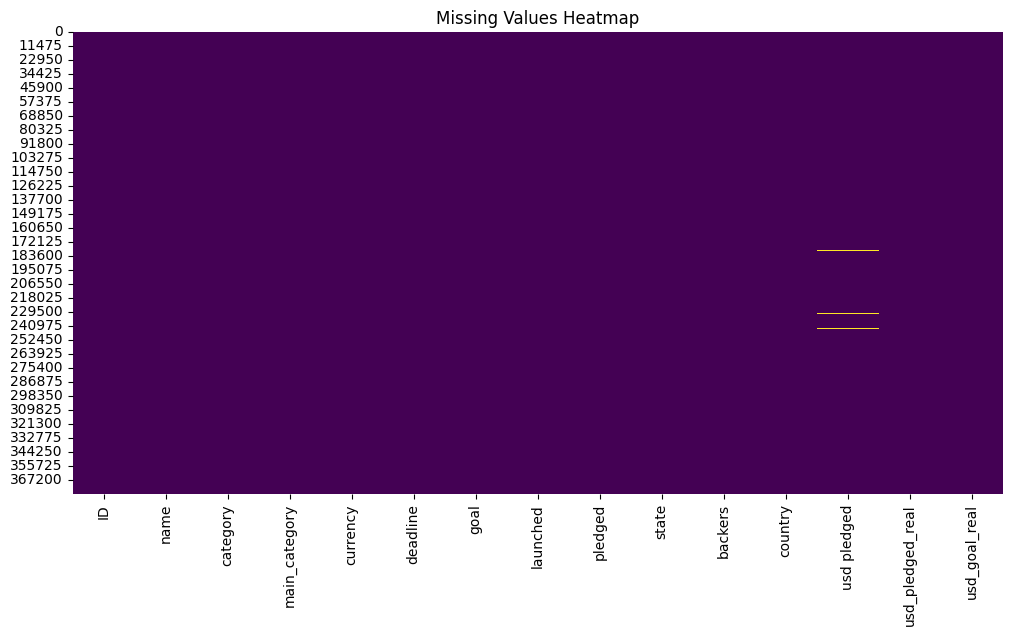

In [125]:
# Visualize missing values heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

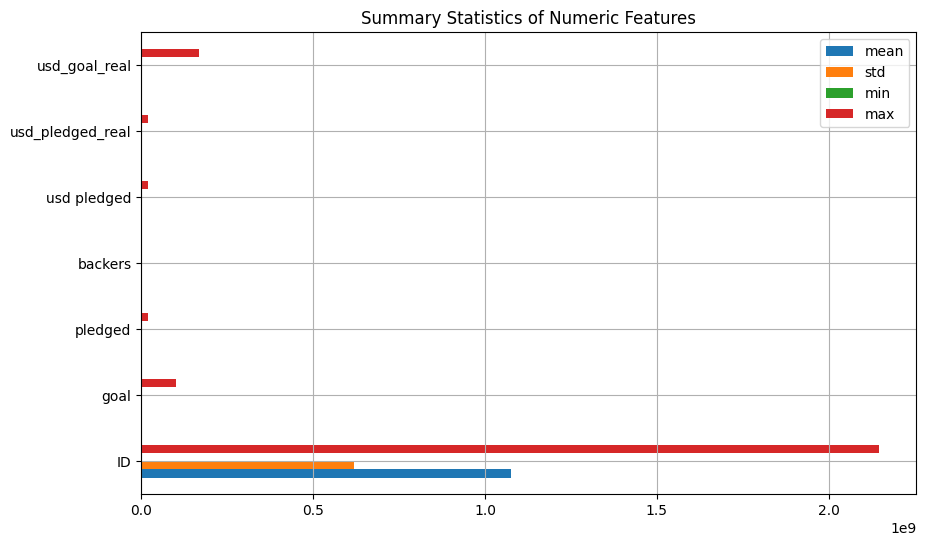

In [126]:
# Show numeric feature distribution
data.describe().T[['mean', 'std', 'min', 'max']].plot(kind='barh', figsize=(10, 6))
plt.title('Summary Statistics of Numeric Features')
plt.grid(True)
plt.show()

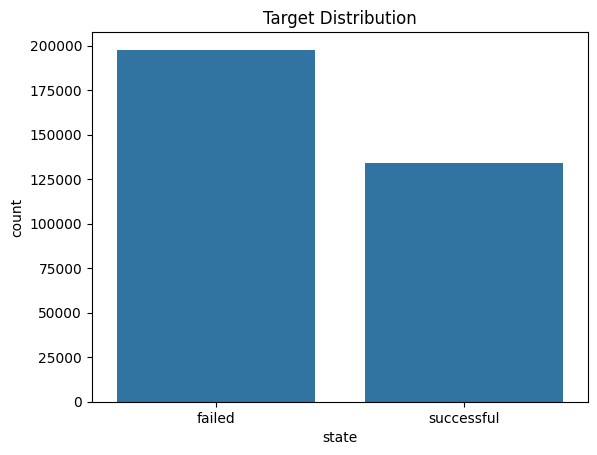

In [127]:
sns.countplot(data=data[data['state'].isin(['failed', 'successful'])], x='state')
plt.title('Target Distribution')
plt.show()

### 3. Data Cleaning

In [128]:
# Drop ID and name columns
data = data.drop(['ID', 'name'], axis=1)

In [129]:
# Keep only failed and successful states
data = data[data['state'].isin(['failed', 'successful'])].reset_index(drop=True)

In [130]:
# Fill missing values in usd pledged
data['usd pledged'] = data['usd pledged'].fillna(data['usd pledged'].mean())

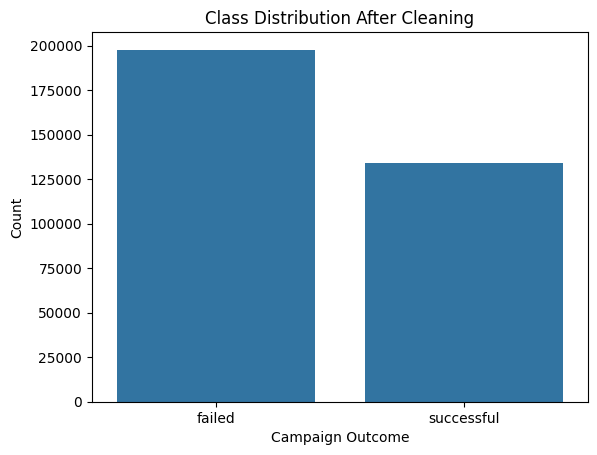

In [131]:
# Visualize cleaned class distribution
sns.countplot(x='state', data=data)
plt.title('Class Distribution After Cleaning')
plt.xlabel('Campaign Outcome')
plt.ylabel('Count')
plt.show()

In [136]:
# Drop potential data leakage columns
leakage_cols = ['pledged', 'usd pledged', 'usd_pledged_real', 'backers']
for col in leakage_cols:
    if col in data.columns:
        data = data.drop(col, axis=1)

### 4. Feature Engineering

In [132]:
# Convert deadline and launched to datetime
data['deadline'] = pd.to_datetime(data['deadline'], errors='coerce')
data['launched'] = pd.to_datetime(data['launched'], errors='coerce')

In [133]:
# Drop rows with missing dates
data = data.dropna(subset=['deadline', 'launched'])

In [134]:
# Feature engineering: duration, month, day of week, weekend, holiday
data['duration_days'] = (data['deadline'] - data['launched']).dt.days
data['launch_month'] = data['launched'].dt.month
data['launch_dow'] = data['launched'].dt.dayofweek
data['launch_weekend'] = data['launch_dow'].isin([5, 6]).astype(int)
data['launch_holiday'] = data['launch_month'].isin([11, 12]).astype(int)

In [135]:
# Log transform goal and create goal_per_day
data['log_goal'] = np.log1p(data['goal'])
data['goal_per_day'] = data['log_goal'] / data['duration_days'].replace(0, 1)
data = data.drop(['goal', 'deadline', 'launched'], axis=1)

### 5. Visualizing Transformed Goal

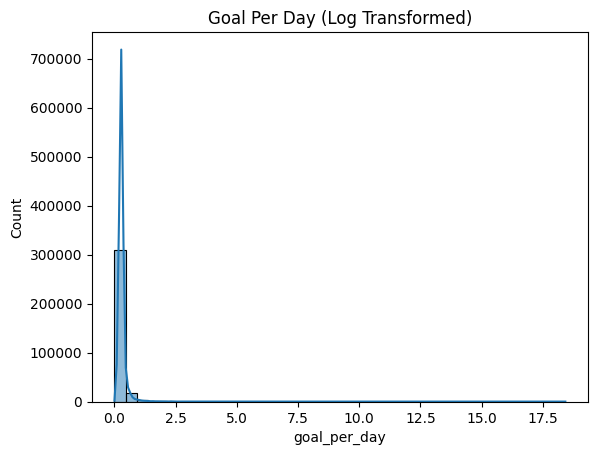

In [137]:
# Visualizing Transformed Goal
sns.histplot(data['goal_per_day'], bins=40, kde=True)
plt.title('Goal Per Day (Log Transformed)')
plt.show()

### 6. Encoding Categorical Features

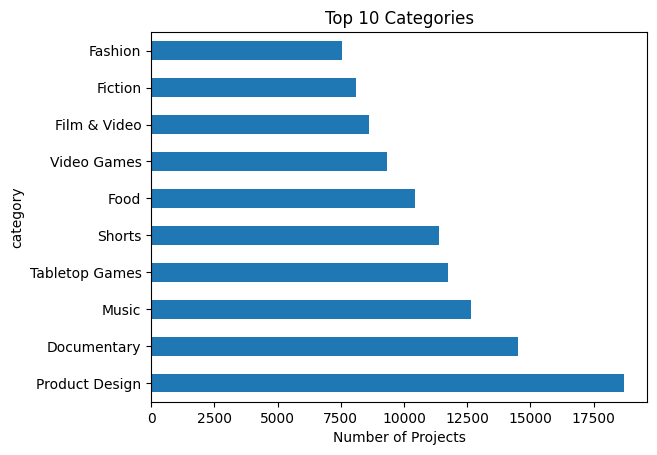

In [138]:
# Visualize top categories
top_cats = data['category'].value_counts().head(10)
top_cats.plot(kind='barh', title='Top 10 Categories')
plt.xlabel('Number of Projects')
plt.show()

In [139]:
# Encoding categorical features
data['state'] = data['state'].map({'failed': 0, 'successful': 1})
def onehot_encode(df, columns, prefixes):
    for col, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[col], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(col, axis=1)
    return df
cat_cols = ['category', 'main_category', 'currency', 'country']
cat_prefix = ['cat', 'main', 'curr', 'cnt']
data = onehot_encode(data, cat_cols, cat_prefix)

### 7. Train-Test Split and Scaling

In [ ]:
# Separate features and target
y = data['state']
X = data.drop('state', axis=1)

In [ ]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [ ]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Class balance in train and test
print("Train target balance:")
print(y_train.value_counts(normalize=True))
print("Test target balance:")
print(y_test.value_counts(normalize=True))